# **1. Predict <u>churn probability</u> per user**

Predict <u>churn probability</u> per user at the last date in the dataset, using purchase history.

Run Kernel → Restart & Run All. `[Set FORCE_REBUILD=True to recompute artifacts.]`

**GitHub**:  https://github.com/nil-alami/Customer_Churn 

#### **Assumptions**:
- in preprocessing/Duplication: Exact Duplicated items are `systemic bias` not user behavior.
- Two approaches: a no ML heuristic + an unsupervised k-means clustering.

#### **Constraints**:
- no labels exist
- no sequences per fixed time window.

#### **Output**:
    one probability per user


In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score

# **2. Load & inspect data**

In [48]:
df_raw = pd.read_csv("dataset.csv")
df_cleaned = df_raw.copy()
df_raw.head()

,UserId,Type,PurchasedAt,PurchasedAmount
0,9,1,3/9/2019,974460
1,17,1,3/12/2019,3248200
2,20,1,3/13/2019,974460
3,28,1,3/19/2019,974460
4,29,1,3/23/2019,974460


In [49]:
df_raw.describe()

,UserId,Type,PurchasedAmount
count,278166.000000,278166.000000,2.781660e+05
mean,100482.220829,1.655044,6.179461e+06
std,52613.138455,1.239377,1.357164e+07
min,1.000000,1.000000,1.000000e+03
25%,53044.000000,1.000000,1.992000e+06
50%,98232.000000,1.000000,3.289875e+06
75%,147804.750000,1.000000,5.636834e+06
max,202320.000000,4.000000,9.572285e+08


In [50]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278166 entries, 0 to 278165
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   UserId           278166 non-null  int64 
 1   Type             278166 non-null  int64 
 2   PurchasedAt      278166 non-null  object
 3   PurchasedAmount  278166 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 8.5+ MB


In [52]:
unique_user_count = df_raw["UserId"].nunique()
print("unique_user_count : ",unique_user_count)

unique_user_count :  60396


# **3. Preprocessing**

**output**: A clean transactional dataset

### 3-1. Duplication
(exact row duplicates)

In [53]:
n_rows = len(df_raw)
n_users = df_raw['UserId'].nunique()

dup_mask = df_raw.duplicated()   # defaults to keep='first'
n_dupes = int(dup_mask.sum())
dup_pct = (n_dupes / n_rows) * 100

print(f"number of exact duplicates: {n_dupes}  # keep='first'")
print(f"percentage of duplication in dataset: {dup_pct:.2f}%")

dup_group_mask = df_raw.duplicated(keep=False)  # all
dup_rows = df_raw.loc[dup_group_mask]

affected_users = dup_rows['UserId'].nunique()
pct_users_affected = (affected_users / n_users) * 100

print(f"Users affected by duplicates: {affected_users}")
print(f"percentage of Users affected: {pct_users_affected:.2f}%")

# Which users are worst affected?
print(dup_rows['UserId'].value_counts().head(10))  

# Dedup
df_cleaned = df_raw.loc[~dup_mask].copy()  # (keeps first exact duplicate)

# Re-check
print("number of exact duplicates (after dedup):", 
      int(df_cleaned.duplicated().sum()))


number of exact duplicates: 5069  # keep='first'
percentage of duplication in dataset: 1.82%
Users affected by duplicates: 2968
percentage of Users affected: 4.91%
UserId
52007     73
65462     64
25915     62
65963     60
26162     52
51965     36
92993     34
1663      32
176261    31
25000     30
Name: count, dtype: int64
number of exact duplicates (after dedup): 0


**Dedup report**\
Duplication at Row-level view => Low\
Duication at t User-level view => (≈ 1 in 20 users) not small.\
Duplicates are not evenly distributed.\
A small set of users are heavily duplicated. These users will:
- Look hyper-active
- Look ultra-loyal
- Dominate frequency-based features
- Skew clustering centroids

Dropping it prevents:
- inflated Frequency features
- artificially small Recency features

62

### 3-2. "PurchasedAt" feature

needs to be Converted to `pandas datetime`. (for feature engineering such as recency, inter-purchase gaps, customer tenure and ...) \
`object(str) → datetime64[ns]`


In [54]:
df = df_cleaned
df['PurchasedAt'] = pd.to_datetime(df['PurchasedAt'], errors='coerce')
df.info()

min_date = df['PurchasedAt'].min()
max_date = df['PurchasedAt'].max()
print("\n min date: {},\n max date : {}".format(min_date,max_date))

<class 'pandas.core.frame.DataFrame'>
Index: 273097 entries, 0 to 278165
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   UserId           273097 non-null  int64         
 1   Type             273097 non-null  int64         
 2   PurchasedAt      273097 non-null  datetime64[ns]
 3   PurchasedAmount  273097 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 10.4 MB

 min date: 2019-03-09 00:00:00,
 max date : 2025-12-06 00:00:00


### 3-3. "PurchasedAmount" feature

In [55]:
df = df[df['PurchasedAmount'] > 0]   # zero|negative amounts are invalid

### 3-4. "Type" feature
It's categorical.

In [56]:
# checking only allowed-values
invalid = df.loc[~df['Type'].isin({1, 4}), 'Type']
print(f"Invalid Type rows: {len(invalid)}")

Invalid Type rows: 0


### 3-5. Sorting

If the data isn’t sorted by time per user, might get:
- negative gaps
- wrong average gap
- wrong “last purchase” logic

In [57]:
df = df.sort_values(['UserId', 'PurchasedAt']).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273097 entries, 0 to 273096
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   UserId           273097 non-null  int64         
 1   Type             273097 non-null  int64         
 2   PurchasedAt      273097 non-null  datetime64[ns]
 3   PurchasedAmount  273097 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 8.3 MB


# **4. Feature engineering**

The raw dataset is <u>transactional</u>, with one row per purchase event. Since churn is defined at the <u>customer level</u>, the data was aggregated to a **user-level representation**.

Each user is represented by a single row of `behavioral features` derived from their purchase history, such as recency, frequency, and monetary value `(RFM-style features)`. 

- **Recency**: How long since the user last purchased?
- **Frequency**: How often did the user purchase?
- **Monetary**: How much value did the user generate?
  
 **output**: a user-level DataFrame 

In [65]:
max_date = df['PurchasedAt'].max()  # global reference time

# user_level df
user_features = (df.groupby('UserId').agg(
        first_purchase_date=('PurchasedAt', 'min'),  # recency
        last_purchase_date=('PurchasedAt', 'max'),  # recency

        total_purchases=('PurchasedAt', 'count'),  # frequency

        total_spend=('PurchasedAmount', 'sum'),  # Monetary
        avg_spend=('PurchasedAmount', 'mean')   # Monetary
    ).reset_index())

# recency
user_features['recency_days'] = (max_date - user_features['last_purchase_date']).dt.days

# Days between consecutive purchases
df['gap_days'] = (df.groupby('UserId')['PurchasedAt'].diff().dt.days)  # NaT for first purchase
gap_features = (df.groupby('UserId')['gap_days']
      .agg(
          avg_gap_days='mean', # average time between purchases 
          max_gap_days='max'  # max gap between purchases 
      ).reset_index())
user_features = user_features.merge(gap_features, on='UserId', how='left')
user_features.head()


# frequency: num_active_days (number of unique purchase dates)
num_active_days = (df.groupby('UserId')['PurchasedAt']
      .nunique()
      .rename('num_active_days')
      .reset_index())
user_features = user_features.merge(num_active_days, on='UserId', how='left')


# recency_gap_ratio (Recency anomaly)
user_features['recency_to_avg_gap'] = (user_features['recency_days'] / user_features['avg_gap_days'])

# "Type(product)" behavior features
type_features = df.groupby('UserId').agg(
    num_prod_A=('Type', lambda x: (x == 1).sum()),
    num_prod_B=('Type', lambda x: (x == 4).sum())
)

user_features = user_features.merge(type_features, on='UserId', how='left')

# Convert to proportions
user_features['share_A'] = user_features['num_prod_A'] / user_features['total_purchases']
user_features['share_B'] = user_features['num_prod_B'] / user_features['total_purchases']
user_features = user_features.drop(columns=['num_prod_A','num_prod_B'])

# Monetary behavior features (from PurchasedAmount)
# log Transform Monetary behavior features (for clustering) (log1p no -inf)
user_features['log_total_spend'] = np.log1p(user_features['total_spend'])
user_features['log_avg_spend'] = np.log1p(user_features['avg_spend'])
user_features = user_features.drop(columns=['total_spend','avg_spend'])

# Tenure & activity
"""
customer_age_days, active_ratio
distinguish new inactive users from long-term inactive users and to capture engagement consistency over time.
"""
user_features['customer_age_days'] = (max_date - user_features['first_purchase_date']).dt.days

# active_ratio
den = user_features['customer_age_days'].replace(0, np.nan)
user_features['active_ratio'] = user_features['num_active_days'] / den
user_features['active_ratio'] = user_features['active_ratio'].fillna(0.0)

user_features.head()

,UserId,first_purchase_date,last_purchase_date,total_purchases,recency_days,avg_gap_days,max_gap_days,num_active_days,recency_to_avg_gap,share_A,share_B,log_total_spend,log_avg_spend,customer_age_days,active_ratio
0,1,2020-01-07,2024-12-29,24,342,79.043478,626.0,21,4.326733,0.875000,0.125000,13.212506,10.034494,2160,0.009722
1,2,2019-12-24,2020-01-14,3,2153,10.500000,21.0,2,205.047619,0.666667,0.333333,14.544730,13.446118,2174,0.000920
2,9,2019-03-09,2019-03-09,1,2464,NaN,NaN,1,NaN,1.000000,0.000000,13.789640,13.789640,2464,0.000406
3,14,2019-08-04,2022-11-14,5,1118,299.500000,851.0,5,3.732888,0.600000,0.400000,15.435300,13.825863,2316,0.002159
4,17,2019-03-12,2023-06-11,4,909,517.333333,824.0,4,1.757088,0.250000,0.750000,15.859092,14.472798,2461,0.001625


### 4-4. Visualizations

One feature redundancy was identified between total purchases and number of active days, so the latter was removed.\
The remaining features exhibit complementary information suitable for distance-based clustering.

#### 4-4-1. Correlation heatmap
to inspect <u>relationships</u> and <u>redundancy</u> among core behavioral features prior to clustering.

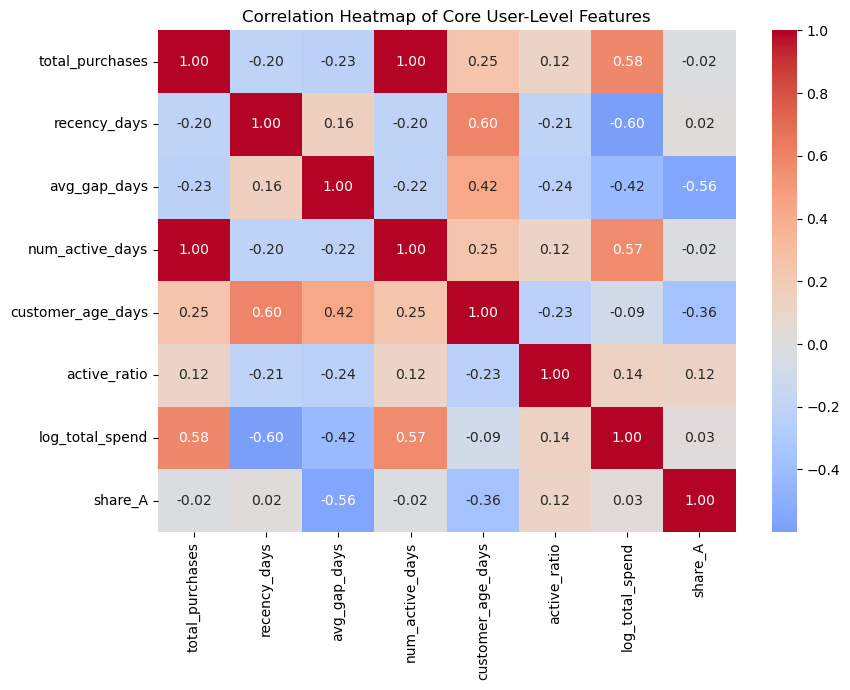

In [59]:
corr_features = [
    'total_purchases',
    'recency_days',
    'avg_gap_days',
    'num_active_days',
    'customer_age_days',
    'active_ratio',
    'log_total_spend',
    'share_A'
]

corr = user_features[corr_features].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap of Core User-Level Features")
plt.tight_layout()
plt.show()

total_purchases ↔ num_active_days = 1.00 they are perfectly correlated, they are encoding the same information. **drop ONE of them before K-Means.** \
num_active_days Dropped.

#### Recency relationships
- recency_days vs log_total_spend → -0.60
- recency_days vs customer_age_days → +0.60\
Users who haven’t purchased recently tend to: have lower lifetime value, and be older customers who stopped engaging [exactly what churn looks like.]

#### Gap-based features
- avg_gap_days vs recency_days → +0.16 (mild)
- avg_gap_days vs share_A → -0.56 (strong)\
Users with larger gaps tend to favor product B. Not redundant with recency → keep avg_gap_days

active_ratio has low correlation with most features [adds information] can help separate edge cases (new vs old inactive users)

Feature set is mostly well-chosen, with one clear redundancy.
"""
log_avg_spend (optional if highly correlated) [adds little]
max_gap_days [Often noisy & extreme]
recency_to_avg_gap [Derived feature → inflates correlations]
"""

#### 4-4-2. recency_days Histogram
Directly reflects churn risk and Shows active vs inactive user mass\
Recency is the strongest behavioral indicator of churn; this distribution helps identify inactive user segments.

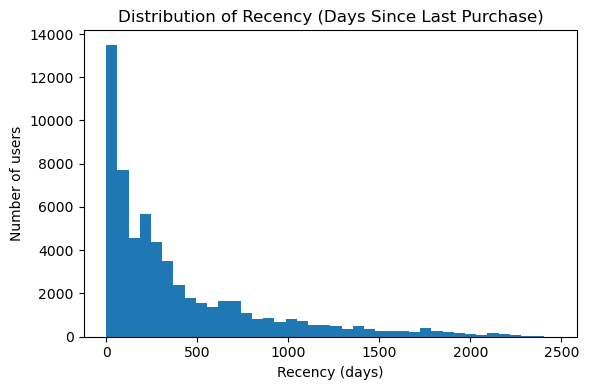

In [44]:
plt.figure(figsize=(6, 4))
plt.hist(user_features['recency_days'], bins=40)
plt.title("Distribution of Recency (Days Since Last Purchase)")
plt.xlabel("Recency (days)")
plt.ylabel("Number of users")
plt.tight_layout()
plt.show()

Huge spike near low recency (0–50 days). Very long right tail up to ~2500 days.
There are two dominant populations:
Recently active users
- Purchased recently
- Likely active
- Low churn risk

Long inactive users
- Haven’t purchased for a very long time
- Likely churned or dormant
- High churn risk

This separation is exactly what churn models rely on. It is not uniform → there is structure. It is right-skewed → expected for recency. It clearly suggests multiple behavioral segments [K-Means will naturally separate clusters along recency]

#### 4-4-3. log_total_spend Histogram
Shows monetary stratification. Also, Total spend was heavily right-skewed; log transformation stabilizes scale and improves clustering behavior.

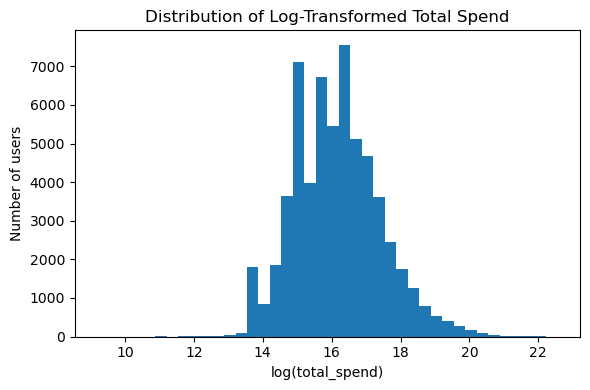

In [60]:
plt.figure(figsize=(6, 4))
plt.hist(user_features['log_total_spend'], bins=40)
plt.title("Distribution of Log-Transformed Total Spend")
plt.xlabel("log(total_spend)")
plt.ylabel("Number of users")
plt.tight_layout()
plt.show()

“Did the log transform fix the skew?” Yes. Perfectly.
Spend will not dominate K-Means distances and Monetary dimension is now stable.

They are telling you:
- Your feature engineering worked
- Your assumptions are valid
- Your data is clusterable



UserId                   
first_purchase_date
last_purchase_date 

share_B
num_active_days


avg_spend
recency_days
avg_gap_days
max_gap_days 
recency_to_avg_gap
share_A
log_total_spend
log_avg_spend      
customer_age_days           
active_ratio 

#### 4-4-4. remove redundant features

In [68]:
#remove redundant features 
user_features = user_features.drop(columns=['num_active_days','share_B'],errors='ignore')  # this was decided from the following visualizations
print(user_features.columns)

Index(['UserId', 'first_purchase_date', 'last_purchase_date',
       'total_purchases', 'recency_days', 'avg_gap_days', 'max_gap_days',
       'recency_to_avg_gap', 'share_A', 'log_total_spend', 'log_avg_spend',
       'customer_age_days', 'active_ratio'],
      dtype='object')


### 4-5. Sanity checks

#### 4-5-1. Missing values
Check for No NaNs before K-Means. 
These have null values (users with 1 purchase → no gaps: NaN):
- avg_gap_days  
- max_gap_days
- recency_to_avg_gap
  
NaN → filled with recency_days [the only gap is time since that purchase]

In [71]:
user_features['avg_gap_days'] = user_features['avg_gap_days'].fillna(
    user_features['recency_days'])

user_features['max_gap_days'] = user_features['max_gap_days'].fillna(
    user_features['recency_days'])

user_features['recency_to_avg_gap'] = user_features['recency_to_avg_gap'].replace(
    [np.inf, -np.inf], np.nan).fillna(1.0)  # Neutral ratio

assert user_features.isna().sum().sum() == 0

### cache/store the user-level aggregated dataset

- `artifacts/user_features.parquet`
- `artifacts/user_features.csv`

In [72]:
# cache/store the user-level aggregated dataset

ART = Path("artifacts")
ART.mkdir(exist_ok=True)

FORCE_REBUILD = False
USER_FEATS_PATH = ART / "user_features.parquet"
USER_FEATS_CSV = ART / "user_features.csv"

def build_user_features(events_clean: pd.DataFrame) -> pd.DataFrame:
    # ... your RFM + aggregation ...
    return user_features

if USER_FEATS_PATH.exists() and not FORCE_REBUILD:
    user_features = pd.read_parquet(USER_FEATS_PATH)
else:
    user_features = build_user_features(df)
    user_features.to_parquet(USER_FEATS_PATH, index=False)
    user_features.to_csv(USER_FEATS_CSV, index=False)


#### 4-5-1. Scaling
StandardScaler

In [75]:
from sklearn.preprocessing import StandardScaler

user_ids = user_features['UserId'].values  # later to map clusters back to users.

model_features = [
    'total_purchases',
    'recency_days',
    'avg_gap_days',
    'recency_to_avg_gap',
    'share_A',
    'log_total_spend',
    'log_avg_spend',
    'active_ratio',
    'customer_age_days',
    'max_gap_days'
]

X = user_features[model_features].copy()

scaler = StandardScaler()

X = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

X.head()
X.info()
X.isna().sum()

,total_purchases,recency_days,avg_gap_days,recency_to_avg_gap,share_A,log_total_spend,log_avg_spend,active_ratio,customer_age_days,max_gap_days
0,2.564418,-0.129472,-0.571592,-0.045239,0.342859,-2.333607,-6.137325,-0.045081,2.336881,0.570038
1,-0.200350,3.787367,-0.740862,3.789585,-0.459516,-1.278387,-2.065358,-0.298813,2.360751,-0.917117
2,-0.463661,4.460000,5.318150,-0.108797,0.824285,-1.876474,-1.655346,-0.313633,2.855209,5.088040
3,0.062961,1.548864,-0.027166,-0.056585,-0.716276,-0.572990,-1.612111,-0.263100,2.602865,1.123112
4,-0.068694,1.096838,0.510782,-0.094333,-2.064267,-0.237315,-0.839958,-0.278479,2.850094,1.056743


In [76]:
X.head()
X.info()
X.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60396 entries, 0 to 60395
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_purchases     60396 non-null  float64
 1   recency_days        60396 non-null  float64
 2   avg_gap_days        60396 non-null  float64
 3   recency_to_avg_gap  60396 non-null  float64
 4   share_A             60396 non-null  float64
 5   log_total_spend     60396 non-null  float64
 6   log_avg_spend       60396 non-null  float64
 7   active_ratio        60396 non-null  float64
 8   customer_age_days   60396 non-null  float64
 9   max_gap_days        60396 non-null  float64
dtypes: float64(10)
memory usage: 4.6 MB


total_purchases       0
recency_days          0
avg_gap_days          0
recency_to_avg_gap    0
share_A               0
log_total_spend       0
log_avg_spend         0
active_ratio          0
customer_age_days     0
max_gap_days          0
dtype: int64

# **5. Model Training** 

read from user_features parquet?

#thresholding for churn flags
Choosing K (elbow / silhouette) and fitting K-Means
mark one or more clusters as high churn risk (“hibernating”, “at risk”, etc.) and derive probabilities from distances or mixture weights.
•  Thresholding comes after clustering
•  First cluster → then interpret → then assign churn risk


### **5-1. Approach 1 – Heuristic churn model (no ML)**

based on RFM features, we can say a user is at risk of churn if the time since their last purchase is large relative to their typical purchase frequency and historical value.

In [ ]:
# 1- Compute each user’s typical purchase frequency (how often this user usually buys.)

df_h = user_features.copy()  # new dataFrame for heuristic approach

df_h['typical_gap_days'] = (df_h['customer_age_days'] / df_h['total_purchases'])

# Safety: handle division edge cases
df_h['typical_gap_days'] = df_h['typical_gap_days'].replace(
    [np.inf, -np.inf], np.nan).fillna(df_h['recency_days'])

# 2- Compare recency against typical behavior
# if recency_days ≫ typical_gap_days then the user is late relative to their normal rhythm → churn risk.
df_h['recency_to_typical_gap'] = (df_h['recency_days'] / df_h['typical_gap_days'])

df_h['recency_to_typical_gap'] = df_h['recency_to_typical_gap'].replace(
    [np.inf, -np.inf], np.nan).fillna(1.0)  # neutral ratio
# ≈ 1 → normal,The user is buying on schedule
# > 1 → late
# >> 1 → very late (strong churn signal)

# 3- Normalize features (min-max) [all components on the same scale [0,1]]
# min-max : interpretable(0 = worst possible, 1 = best possible) vs StandardScaler(-1.73 or +0.42)
#.........: The final output is a probability [0,1]
"""
Features to normalize
- recency_days
- total_purchases
- log_total_spend (or total_spend)
why these?
"""
def min_max_norm(x):
    return (x - x.min()) / (x.max() - x.min())

df_h['recency_norm'] = min_max_norm(df_h['recency_days'])
df_h['freq_norm']    = min_max_norm(df_h['total_purchases'])
df_h['monetary_norm']= min_max_norm(df_h['log_total_spend'])

# 4- make heuristic churn score

features we need:
- recency_days
- total_purchases
- customer_age_days
- log_total_spend

### **5-2. Approach 2 – K-Means churn model (unsupervised ML)**

Cluster users into behavioral groups and interpret some clusters as “high churn risk.”

number of clusters: K∈[3, 5]
<3 → too coarse and >7 → hard to interpret, unstable


define random seed , hyper parameters? And … ?

#### 5-2-1. Elbow method

measuring Inertia 
- Inertia = within-cluster sum of squares
- Lower is better, but diminishing returns matter

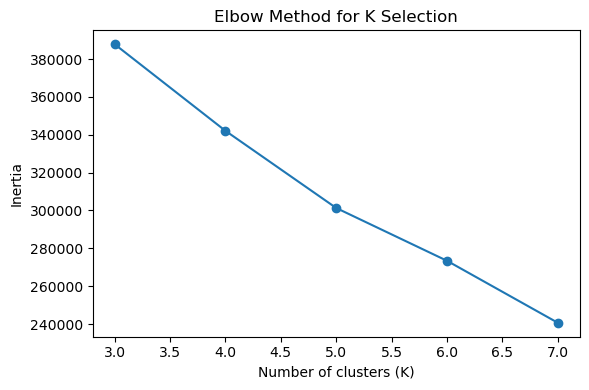

In [93]:
# Elbow method

inertias = []
K_range = range(3,8)

for k in K_range:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    km.fit(X)
    inertias.append(km.inertia_)

# plotting inertia
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K Selection")
plt.tight_layout()
plt.show()

NOT looking for the minimum inertia but for the point where improvement slows down, like a visible “bend”\
Typically for churn data, K = 4 or 5 wins.
bend like an “L-shape”. [although real churn data almost never shows such thing.]
here After K = 5, gains become smaller and inconsistent

#### 5-2-2. Silhouette score
Measures how well clusters are separated.

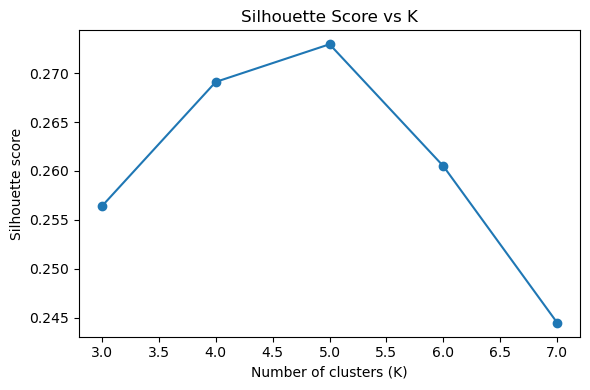

In [88]:
# Silhouette score

sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

# plotting
plt.figure(figsize=(6, 4))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs K")
plt.tight_layout()
plt.show()

Higher silhouette = better separation

Based on the elbow method and silhouette analysis, K=4 was selected as a good trade-off between compactness and interpretability.

In [107]:
# final k-means
k_final = 4

kmeans = KMeans(
    n_clusters=k_final,
    random_state=42,
    n_init=10
)

cluster_labels = kmeans.fit_predict(X)

# Attach clusters to users
user_features['cluster'] = cluster_labels  

# cluster profiles   ??? original, unscaled features
cluster_profiles = (
    user_features  
    .groupby('cluster')
    .mean())

print('done')

done


For each cluster, inspect:
- recency_days ↑ → churn ↑
- total_purchases ↓ → churn ↑
- log_total_spend ↓ → churn ↑
- avg_gap_days ↑ → churn ↑
- active_ratio ↓ → churn ↑

Inspect cluster profiles
- Whichever K gives:
- clearer behavioral separation
- easier churn interpretation

| Cluster | Behavior               | Interpretation  |
| ------- | ---------------------- | --------------- |
| 0       | Low recency, high freq | Active / loyal  |
| 1       | Medium everything      | At-risk         |
| 2       | High recency, low freq | Likely churned  |
| 3       | New, low tenure        | New / undecided |


#### 5-2-3. PCA Scatter Plot

Scatter plot:
- color = cluster label
- dot = user

Are clusters visually separable or overlapping?  

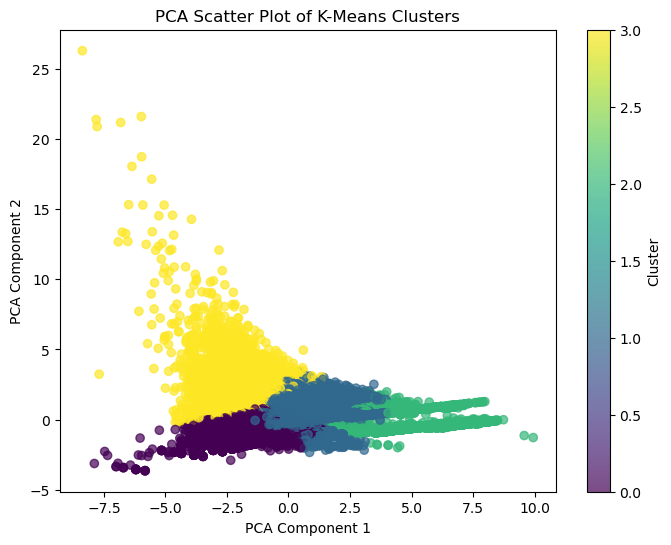

In [108]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA to 2D (for visualization only)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=user_features['cluster'],
    alpha=0.7
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Scatter Plot of K-Means Clusters')
plt.colorbar(label='Cluster')
plt.show()


#### 5-2-4. Cluster Size Bar Chart
Plot:
- x-axis: cluster id
- y-axis: number of users

Extremely small cluster → outliers?, One huge cluster → weak segmentation

Detects tiny clusters, dominance, or bad K choice.

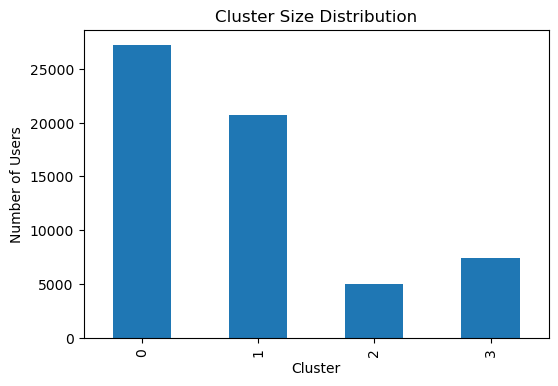

In [109]:
cluster_counts = user_features['cluster'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('Cluster Size Distribution')
plt.show()

#### 5-2-5. Cluster Profile Heatmap

cluster_profiles  # unscaled features

Plot:
- rows = clusters
- columns = features
- values = mean (or median)
- normalize per column (optional, for readability)

Interpretation:
- “Cluster 3 = high spend, low recency, frequent → VIPs”

Which features define each cluster (this is where naming happens).

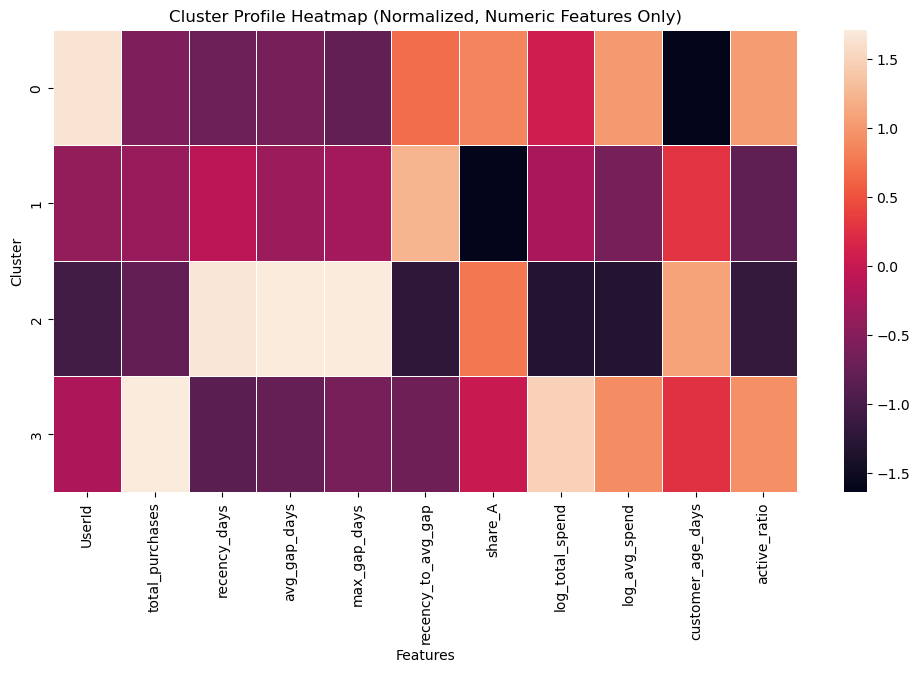

In [99]:
# import seaborn as sns

# # Mean profile on ORIGINAL (unscaled) features
# cluster_profiles = (
#     user_features
#     .groupby('cluster')
#     .mean()
# )

# # Optional: normalize per feature for readability
# cluster_profiles_norm = (
#     cluster_profiles - cluster_profiles.mean()
# ) / cluster_profiles.std()

# plt.figure(figsize=(12, 6))
# sns.heatmap(
#     cluster_profiles_norm,
#     annot=False,
#     cmap='coolwarm',
#     linewidths=0.5
# )
# plt.title('Cluster Profile Heatmap (Normalized)')
# plt.xlabel('Features')
# plt.ylabel('Cluster')
# plt.show()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Keep only numeric features (exclude 'cluster' itself if it became numeric)
numeric_cols = user_features.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'cluster']  # optional safety

# 2) Build cluster profiles on ORIGINAL (unscaled) numeric features
cluster_profiles = (
    user_features
    .groupby('cluster')[numeric_cols]
    .mean()
)

# 3) Normalize per feature for readability (z-score across clusters)
cluster_profiles_norm = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std(ddof=0)

# 4) Clean any bad values (can happen if std=0 for a feature)
cluster_profiles_norm = cluster_profiles_norm.replace([np.inf, -np.inf], np.nan).fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles_norm, linewidths=0.5)
plt.title('Cluster Profile Heatmap (Normalized, Numeric Features Only)')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.show()


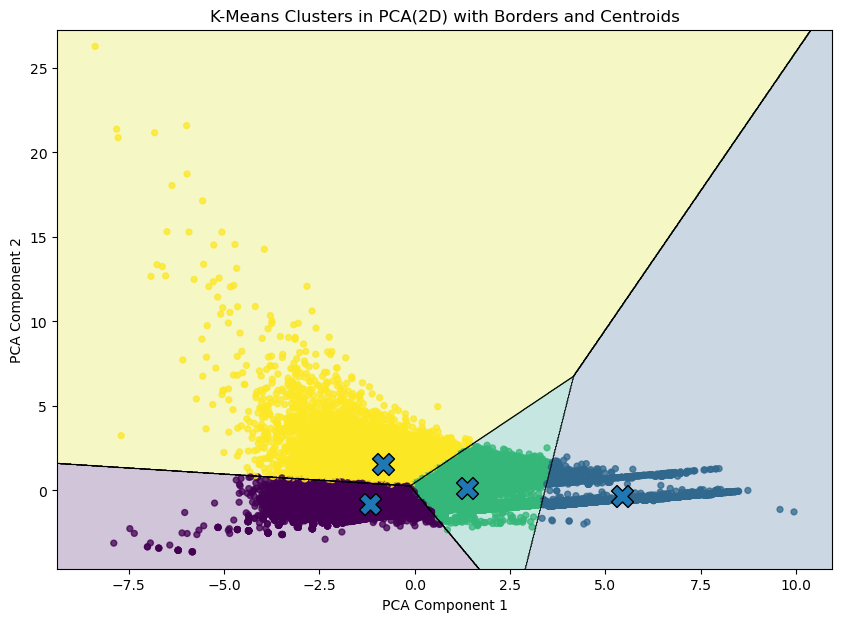

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# --- 1) Project your scaled X to 2D for visualization ---
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)   # X should be scaled already

# --- 2) Fit a KMeans model in this 2D PCA space (for visualization borders) ---
k_final = 4
kmeans_vis = KMeans(n_clusters=k_final, random_state=42, n_init=10)
labels2 = kmeans_vis.fit_predict(X2)
centers2 = kmeans_vis.cluster_centers_

# --- 3) Create a mesh grid and predict cluster for each point -> borders ---
x_min, x_max = X2[:, 0].min() - 1.0, X2[:, 0].max() + 1.0
y_min, y_max = X2[:, 1].min() - 1.0, X2[:, 1].max() + 1.0

h = 0.02  # smaller -> smoother borders (slower)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = kmeans_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# --- 4) Plot: regions (borders), points, and centroids ---
plt.figure(figsize=(10, 7))

# colored regions (decision areas)
plt.contourf(xx, yy, Z, alpha=0.25)

# explicit border lines
plt.contour(xx, yy, Z, colors='k', linewidths=0.6, alpha=0.7)

# scatter points
plt.scatter(X2[:, 0], X2[:, 1], c=labels2, s=18, alpha=0.75)

# centroids
plt.scatter(centers2[:, 0], centers2[:, 1], marker='X', s=250, edgecolor='k')

plt.title("K-Means Clusters in PCA(2D) with Borders and Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


#### 5-2-3. map clusters → probabilities

Check a few extreme users manually:
- high recency → high churn prob
- recent buyers → low churn prob

In [113]:
# interpreting each cluster
cluster_churn_prob = {
    0: 0.05,   # loyal
    1: 0.30,   # at risk
    2: 0.80,   # churned
    3: 0.20    # new users
}
# !! “These users have 0.8 churn probability.”
user_features['churn_prob_kmeans'] = (
    user_features['cluster']
    .map(cluster_churn_prob))

(user_features[['UserId', 'churn_prob_kmeans']]).to_csv("churn_scores.csv", index=False)

user_features['churn_prob_kmeans'].describe()
# """
# You should see:
# - min ≈ 0.05
# - max ≈ 0.8–0.9
# - reasonable spread
# """

count    60396.000000
mean         0.216754
std          0.208305
min          0.050000
25%          0.050000
50%          0.200000
75%          0.300000
max          0.800000
Name: churn_prob_kmeans, dtype: float64

clusters of customers with similar activity patterns

Let’s assume you inspected cluster means and saw something like this:

| Cluster | Recency   | Purchases | Spend  | Interpretation |
| ------- | --------- | --------- | ------ | -------------- |
| 0       | very low  | high      | high   | Loyal          |
| 1       | medium    | medium    | medium | At risk        |
| 2       | very high | low       | low    | Churned        |
| 3       | low       | low       | low    | New         
Then assigning:

Loyal        → very low churn → ~0.05
At risk      → moderate       → ~0.30
Churned      → high           → ~0.80
New users    → uncertain      → ~0.20


This is ordinal and relative, not exact.

The ordering matters more than the exact values.

for numbers:
The absolute values are heuristic and relative; the key outcome is the ranking of users by churn risk. In a production system, these probabilities would be calibrated using historical churn labels.   |


# **6. Comparing / combining the two approaches**

Evaluation?

# **7. Build final churn probabilities**

# **8. Export output file `(churn_p.csv)`**

# **9. Conclusion & possible future work**

Final results summary at the bottom